In [6]:
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

In [7]:
url_boundary = "https://raw.githubusercontent.com/naufalaschafitz/TugasAkhir/refs/heads/main/coordinates_with_region.csv"
url_centroids = "https://raw.githubusercontent.com/naufalaschafitz/TugasAkhir/refs/heads/main/Centroids.csv"
df_boundary = pd.read_csv(url_boundary)
df_centroids = pd.read_csv(url_centroids)

In [16]:
inner_boundaries = {}
for i in range(1, 4):
    points = df_boundary[df_boundary["Region"] == f"inner_{i}"][["X", "Y"]].values
    inner_boundaries[i] = Polygon(np.vstack([points, points[0]]))

centroids_by_region = {}
for i in range(1, 4):
    df = df_centroids[df_centroids["InnerRegion"] == i]
    centroids_by_region[i] = df[["X", "Y"]].values

def compute_uav_coverage_ratio(centroids, boundary_polygon, radius):
    coverage_circles = [Point(cx, cy).buffer(radius) for (cx, cy) in centroids]
    total_coverage_union = unary_union(coverage_circles)
    effective_coverage = total_coverage_union.intersection(boundary_polygon)
    ratio = (effective_coverage.area / boundary_polygon.area) * 100
    return effective_coverage.area, boundary_polygon.area, ratio

def plot_coverage_and_overlap(boundaries, centroids_dict, radius):
    fig, ax = plt.subplots(figsize=(14, 10))
    region_colors = ['black', 'green', 'blue']
    total_inner_area = 0
    total_uncovered_area = 0
    total_overlap_area = 0

    for i, (region_id, boundary) in enumerate(boundaries.items()):
        region_label = f"Inner {region_id}"
        centroids = centroids_dict[region_id]

        # Generate buffer (coverage circles)
        coverage_circles = [Point(cx, cy).buffer(radius) for (cx, cy) in centroids]
        coverage_union = unary_union(coverage_circles)

        # Calculate coverage metrics
        uncovered_area = boundary.difference(coverage_union)
        covered_area = boundary.intersection(coverage_union)

        # Calculate overlapping area
        overlap_area = 0
        for idx1 in range(len(coverage_circles)):
            for idx2 in range(idx1 + 1, len(coverage_circles)):
                intersection = coverage_circles[idx1].intersection(coverage_circles[idx2])
                overlap_area += intersection.area

        # Update totals
        total_inner_area += boundary.area
        total_uncovered_area += uncovered_area.area
        total_overlap_area += overlap_area

        # Plot boundary
        x_inner, y_inner = boundary.exterior.xy
        ax.plot(x_inner, y_inner, color=region_colors[i], linewidth=2, label=f"{region_label} Boundary")

        # Plot covered (green)
        if not covered_area.is_empty:
            geoms = [covered_area] if covered_area.geom_type == 'Polygon' else covered_area.geoms
            for poly in geoms:
                x_cov, y_cov = poly.exterior.xy
                ax.fill(x_cov, y_cov, facecolor='limegreen', alpha=0.4)

        # Plot uncovered (red)
        if not uncovered_area.is_empty:
            geoms = [uncovered_area] if uncovered_area.geom_type == 'Polygon' else uncovered_area.geoms
            for poly in geoms:
                x_uncov, y_uncov = poly.exterior.xy
                ax.fill(x_uncov, y_uncov, facecolor='red', edgecolor='red', linewidth=2.5, alpha=0.8)

        # Plot centroids
        if len(centroids) > 0:
            cx, cy = zip(*centroids)
            ax.scatter(cx, cy, color='black', s=30, marker='x', label=f"{region_label} Centroids")

    # Summary statistics
    uncovered_pct = (total_uncovered_area / total_inner_area) * 100
    overlap_pct = (total_overlap_area / total_inner_area) * 100

    ax.set_title(f"UAV Coverage Visualization\nGreen = Covered, Red = Uncovered ({uncovered_pct:.2f}%)", fontsize=15)
    ax.set_xlabel("Longitude")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc='upper right', fontsize=9)
    ax.set_aspect('equal')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "Total Inner Area (m²)": total_inner_area,
        "Total Uncovered Area (m²)": total_uncovered_area,
        "Total Overlap Area (m²)": total_overlap_area,
        "Uncovered Percentage (%)": uncovered_pct,
        "Overlap Percentage (%)": overlap_pct
    }



In [31]:
# Fungsi untuk menghitung area overlap dalam satu inner region
def compute_uav_overlap_area(centroids, boundary_polygon, radius):
    """
    Menghitung luas overlap cakupan UAV dalam satu inner region.
    Overlap = Total area semua lingkaran - union area yang tercakup dalam boundary.

    Args:
        centroids (array): koordinat centroid UAV
        boundary_polygon (Polygon): batas inner region
        radius (float): radius cakupan UAV

    Returns:
        overlap_area (float): luas overlap dalam m²
        overlap_pct (float): persentase overlap terhadap luas inner
    """
    coverage_circles = [Point(cx, cy).buffer(radius) for (cx, cy) in centroids]
    sum_circle_area = sum(c.area for c in coverage_circles)
    union_area = unary_union(coverage_circles).intersection(boundary_polygon).area
    overlap_area = sum_circle_area - union_area
    overlap_pct = (overlap_area / boundary_polygon.area) * 100
    return overlap_area, overlap_pct

# Ambil luas inner dari masing-masing boundary
inner_1_area = inner_boundaries[1].area
inner_2_area = inner_boundaries[2].area
inner_3_area = inner_boundaries[3].area

# Hitung persentase overlap terhadap inner masing-masing
overlap_pct_1_func = (overlap_area_1_func / inner_1_area) * 100
overlap_pct_2_func = (overlap_area_2_func / inner_2_area) * 100
overlap_pct_3_func = (overlap_area_3_func / inner_3_area) * 100

# Buat dataframe dari hasil overlap
df_overlap_summary = pd.DataFrame([
    {
        "Region": "Inner 1",
        "Luas Area (m²)": inner_1_area,
        "Luas Overlap (m²)": overlap_area_1_func,
        "Persentase Overlap (%)": overlap_pct_1_func
    },
    {
        "Region": "Inner 2",
        "Luas Area (m²)": inner_2_area,
        "Luas Overlap (m²)": overlap_area_2_func,
        "Persentase Overlap (%)": overlap_pct_2_func
    },
    {
        "Region": "Inner 3",
        "Luas Area (m²)": inner_3_area,
        "Luas Overlap (m²)": overlap_area_3_func,
        "Persentase Overlap (%)": overlap_pct_3_func
    },
    {
        "Region": "Total",
        "Luas Area (m²)": inner_1_area + inner_2_area + inner_3_area,
        "Luas Overlap (m²)": total_overlap_area_func,
        "Persentase Overlap (%)": total_overlap_pct_func
    }
])

df_overlap_summary



,Region,Luas Area (m²),Luas Overlap (m²),Persentase Overlap (%)
0,Inner 1,6764.788,3588.050380,53.040101
1,Inner 2,6852.790,3503.155602,51.120136
2,Inner 3,2671.475,3891.090464,145.653261
3,Total,16289.053,10982.296446,67.421332


C:\Users\naufa\AppData\Local\Temp\ipykernel_25508\2639081908.py:51: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


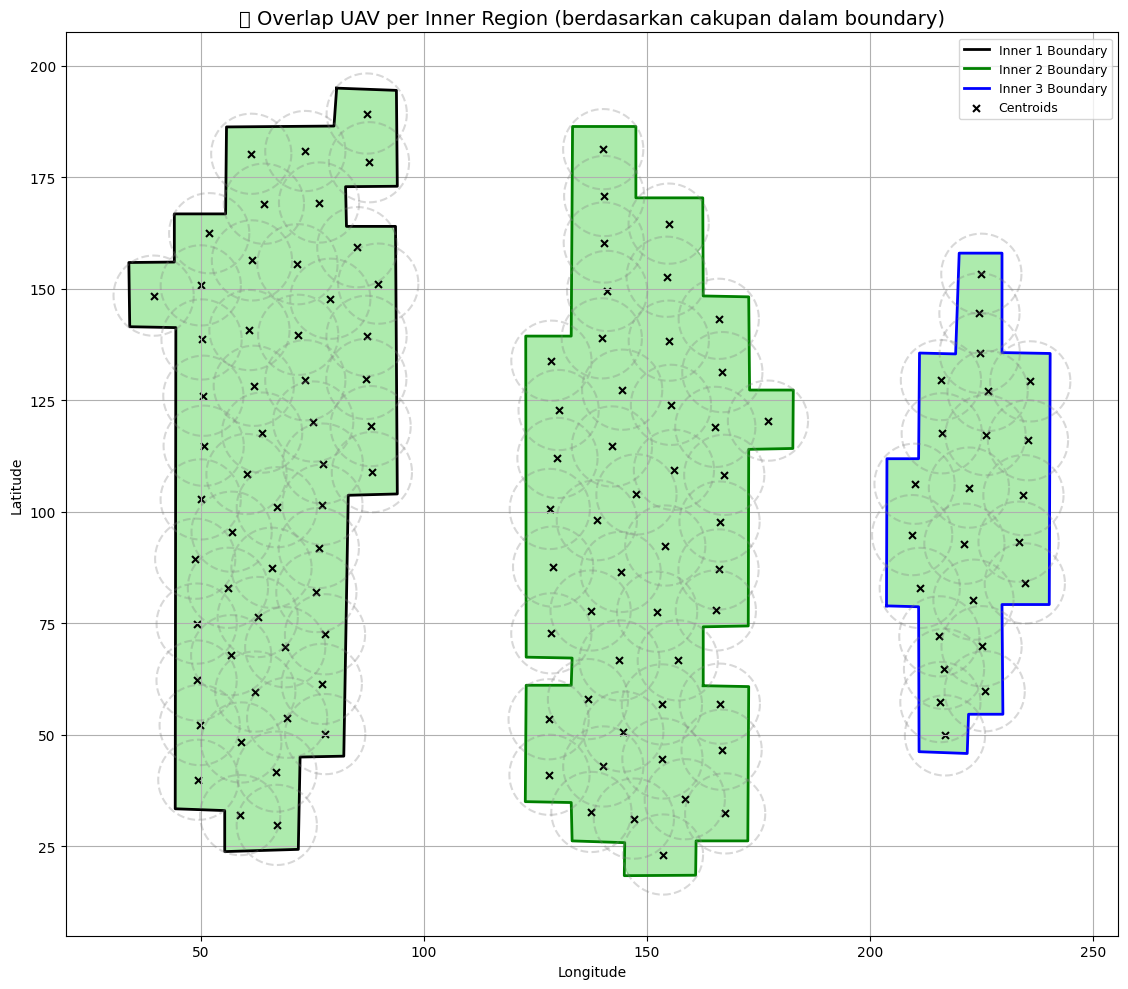

In [33]:
# Visualisasi overlap per-region berdasarkan hasil compute_uav_overlap_area
fig, ax = plt.subplots(figsize=(14, 10))
colors = ['black', 'green', 'blue']

# Loop untuk setiap inner region
for i in range(1, 4):
    boundary = inner_boundaries[i]
    centroids = centroids_by_region[i]

    # Buat lingkaran UAV
    circles = [Point(cx, cy).buffer(radius) for (cx, cy) in centroids]

    # Union dari lingkaran dalam region
    union_shape = unary_union(circles).intersection(boundary)

    # Total area semua lingkaran
    sum_circle_area = sum(c.area for c in circles)

    # Overlap area = area total lingkaran - union
    region_overlap_area = sum_circle_area - union_shape.area

    # 1. Plot boundary inner
    x_b, y_b = boundary.exterior.xy
    ax.plot(x_b, y_b, color=colors[i-1], linewidth=2, label=f"Inner {i} Boundary")

    # 2. Plot semua lingkaran UAV di region tersebut
    for c in circles:
        x_c, y_c = c.exterior.xy
        ax.plot(x_c, y_c, color='gray', linestyle='--', alpha=0.3)

    # 3. Plot area union (cakupan efektif dalam inner)
    if union_shape.geom_type == 'Polygon':
        x_u, y_u = union_shape.exterior.xy
        ax.fill(x_u, y_u, color='limegreen', alpha=0.4)
    elif union_shape.geom_type == 'MultiPolygon':
        for g in union_shape.geoms:
            x_u, y_u = g.exterior.xy
            ax.fill(x_u, y_u, color='limegreen', alpha=0.4)

# 4. Plot semua centroid
cx, cy = zip(*all_centroids)
ax.scatter(cx, cy, color='black', s=25, marker='x', label="Centroids")

# Finalisasi plot
ax.set_title("🎯 Overlap UAV per Inner Region (berdasarkan cakupan dalam boundary)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True)
plt.tight_layout()
plt.show()

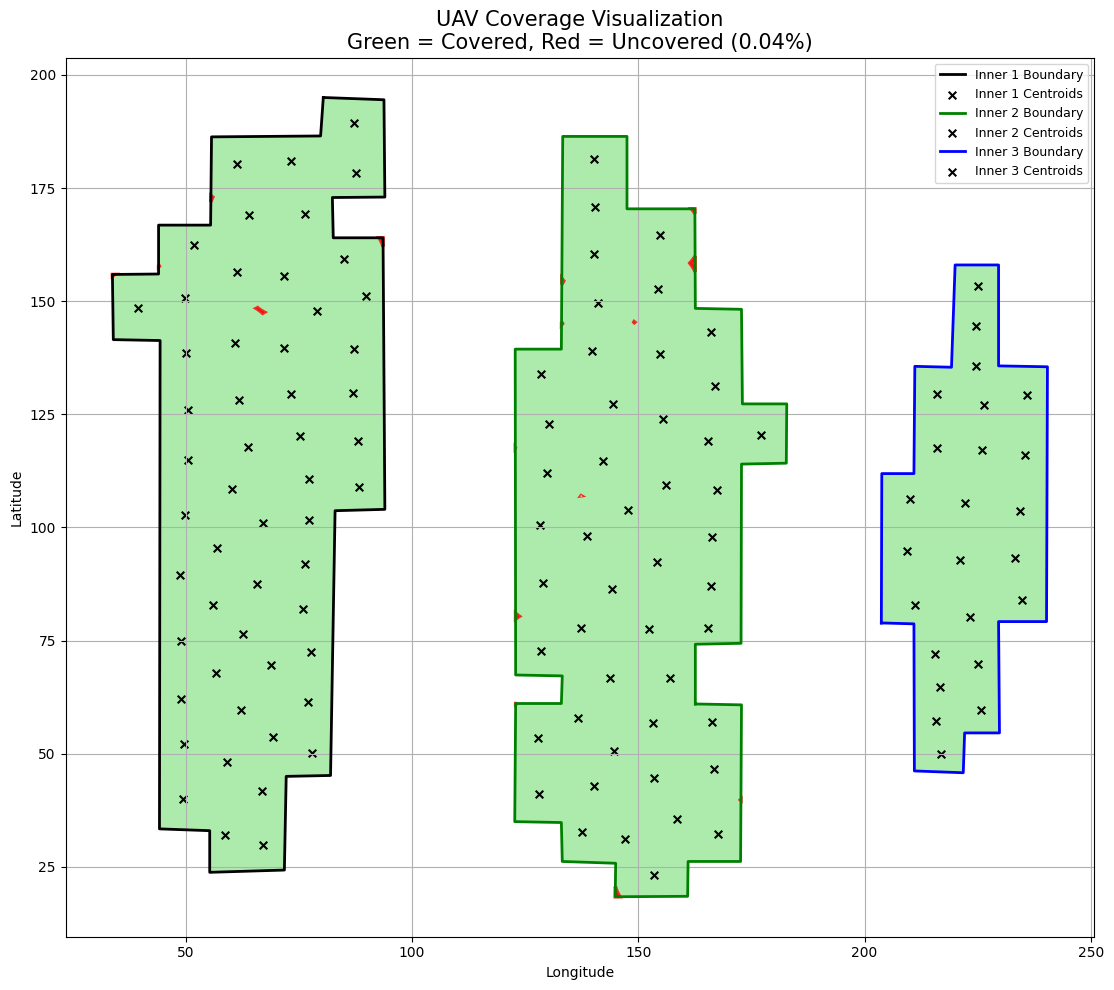

    Region  Covered Area (m²)  Total Area (m²)  Coverage Ratio (%)
0  Inner 1        6763.017105         6764.788           99.973822
1  Inner 2        6848.513690         6852.790           99.937598
2  Inner 3        2671.475000         2671.475          100.000000
3    Total       16283.005795        16289.053           99.962876


In [12]:
radius = 9
coverage_summary = []
for i in range(1, 4):
    covered, total, ratio = compute_uav_coverage_ratio(centroids_by_region[i], inner_boundaries[i], radius)
    coverage_summary.append({
        "Region": f"Inner {i}",
        "Covered Area (m²)": covered,
        "Total Area (m²)": total,
        "Coverage Ratio (%)": ratio
    })

# Add total row
total_covered = sum(r["Covered Area (m²)"] for r in coverage_summary)
total_area = sum(r["Total Area (m²)"] for r in coverage_summary)
total_ratio = (total_covered / total_area) * 100
coverage_summary.append({
    "Region": "Total",
    "Covered Area (m²)": total_covered,
    "Total Area (m²)": total_area,
    "Coverage Ratio (%)": total_ratio
})

df_coverage_summary = pd.DataFrame(coverage_summary)
overlap_stats = plot_coverage_and_overlap(inner_boundaries, centroids_by_region, radius=9)

print(df_coverage_summary)
